In [7]:
import pandas as pd

# Load CpGs inside MEs
cpgs = pd.read_csv('inv_cpgs_within_metastable_epialleles.tsv', sep='\t')

# Load MEs
mes = pd.read_csv("metastable_epiallele_list.csv", sep=",", header=0)
mes = mes.drop(columns=["Hg19 data"])

# Create a function to assign ME ID for each CpG
def assign_me(row):
    for _, me in mes.iterrows():
        if (row['Chr'] == me['Chr']) and (row['Start'] >= me['Start']) and (row['End'] <= me['End']):
            return f"{me['Chr']}:{me['Start']}-{me['End']}"
    return None

# Apply function - WARNING: This can be slow for large datasets
cpgs['ME_ID'] = cpgs.apply(assign_me, axis=1)

# Drop CpGs not in any ME (if any)
cpgs = cpgs.dropna(subset=['ME_ID'])

cpgs = cpgs.drop_duplicates(subset=['Chr', 'Start', 'End', 'ME_ID'])

# Save back if you want
cpgs.to_csv('inv_cpgs_with_ME_ID.tsv', sep='\t', index=False)

In [8]:
print(cpgs.columns)

Index(['Chr', 'Start', 'End', 'ICM_Meth_frac', 'Liver_Meth_frac', 'Naive_mean',
       'Primed_mean', 'Primed_Neuron_mean', 'Formative_mean',
       'Formative_Neuron_mean', 'ME_ID'],
      dtype='object')


In [9]:
renamed_df = cpgs.rename(columns={
    "ICM_Meth_frac": "ICM",
    "Liver_Meth_frac": "Liver",
    "Naive_mean": "Naive",
    "Primed_mean": "Primed",
    "Primed_Neuron_mean": "Primed_Neuron",
    "Formative_mean": "Formative",
    "Formative_Neuron_mean": "Formative_Neuron",
})

In [10]:
print(renamed_df.columns)

Index(['Chr', 'Start', 'End', 'ICM', 'Liver', 'Naive', 'Primed',
       'Primed_Neuron', 'Formative', 'Formative_Neuron', 'ME_ID'],
      dtype='object')


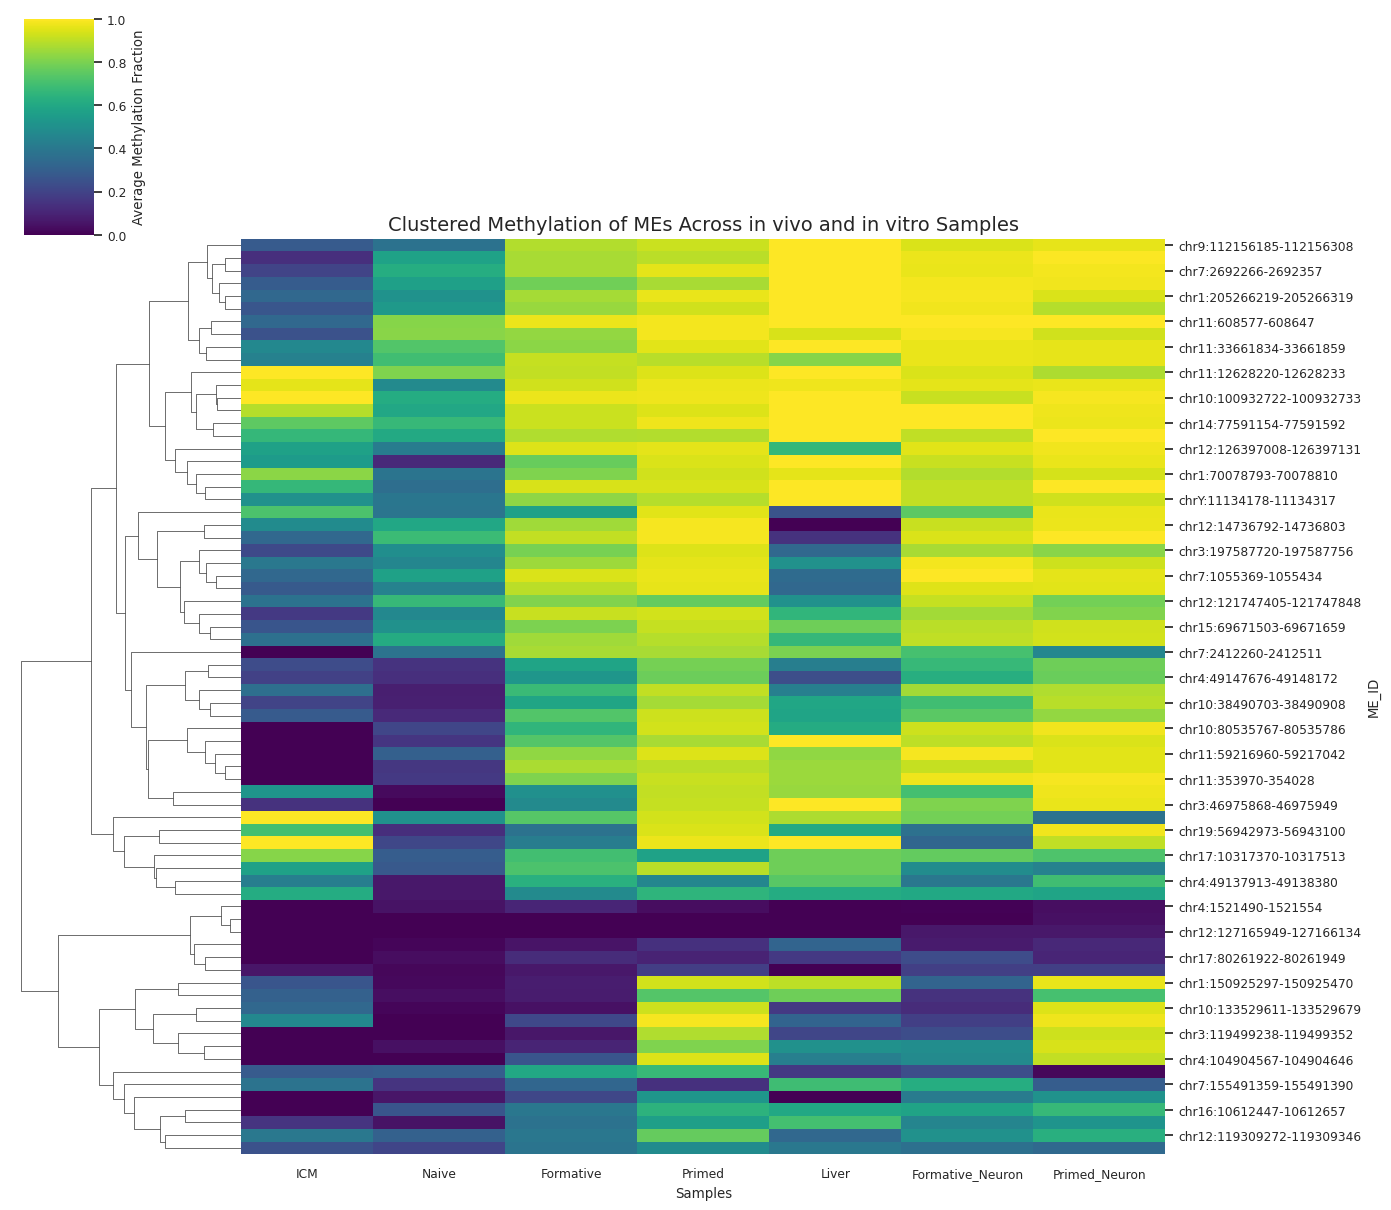

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define sample group order and filter columns
group_order = ['ICM', 'Naive', 'Formative', 'Primed', 'Liver', 'Formative_Neuron', 'Primed_Neuron']
keywords = ['ICM', 'Liver', 'Naive', 'Primed', 'Primed_Neuron', 'Formative', 'Formative_Neuron']

# Columns containing methylation fractions
frac_cols = [col for col in renamed_df.columns if any(kw in col for kw in keywords)]

# Filter to ME-only rows and average per ME_ID
cpgs_me = renamed_df[renamed_df['ME_ID'].notna()]
me_meth_avg = cpgs_me.groupby('ME_ID')[frac_cols].mean()

# Keep columns in order (if present)
ordered_cols = [col for col in group_order if col in me_meth_avg.columns]
me_meth_avg = me_meth_avg[ordered_cols]

# Plotting style
plt.rcParams.update({ 
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

# Plot as clustered heatmap
sns.set(font_scale=0.8)
g = sns.clustermap(
    me_meth_avg,
    cmap='viridis',
    col_cluster=False,  # keep sample order fixed
    row_cluster=True,   # cluster MEs
    figsize=(14, 12),
    cbar_kws={'label': 'Average Methylation Fraction'}
)

g.ax_heatmap.set_title("Clustered Methylation of MEs Across in vivo and in vitro Samples", fontsize=14)
g.ax_heatmap.set_xlabel("Samples")
g.ax_heatmap.set_ylabel("ME_ID")

# Save
g.savefig("clustered_ME_heatmap.pdf", bbox_inches='tight')
g.savefig("clustered_ME_heatmap.svg", bbox_inches='tight')
plt.show()

ICM-like ME_IDs: ['chr19:56942973-56943100', 'chr8:1373139-1373340']
Liver-like ME_IDs: ['chr10:100932722-100932733', 'chr10:38590865-38590941', 'chr11:12628220-12628233', 'chr11:18158776-18159206', 'chr14:77591154-77591592', 'chr19:28816740-28817224', 'chr19:7617819-7617858', 'chr1:70078793-70078810', 'chrY:11134178-11134317', 'chrY:11302305-11302331']


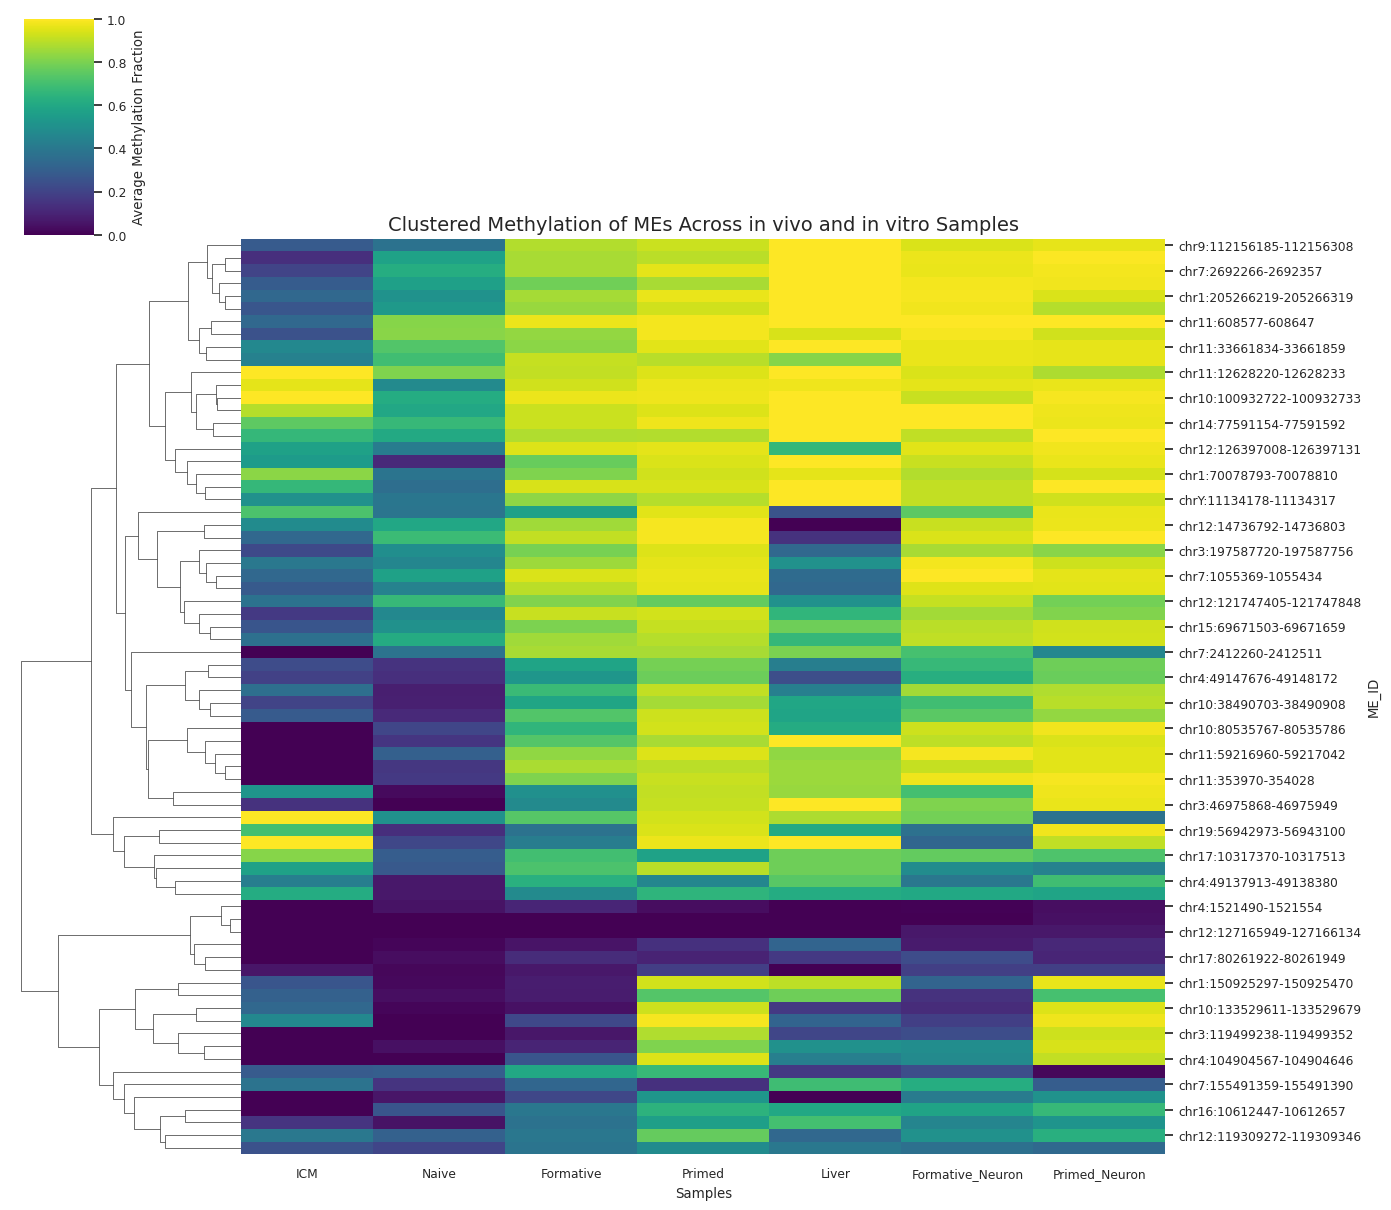

In [27]:
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

# Columns and ME data prep (same as before)
group_order = ['ICM', 'Naive', 'Formative', 'Primed', 'Liver', 'Formative_Neuron', 'Primed_Neuron']
keywords = ['ICM', 'Liver', 'Naive', 'Primed', 'Primed_Neuron', 'Formative', 'Formative_Neuron']
frac_cols = [col for col in renamed_df.columns if any(kw in col for kw in keywords)]

cpgs_me = renamed_df[renamed_df['ME_ID'].notna()]
me_meth_avg = cpgs_me.groupby('ME_ID')[frac_cols].mean()

ordered_cols = [col for col in group_order if col in me_meth_avg.columns]
me_meth_avg = me_meth_avg[ordered_cols]

# Compute linkage for rows (MEs)
row_linkage = linkage(pdist(me_meth_avg.values), method='ward')

# Choose a number of clusters or distance threshold
n_clusters = 10  # You can tweak this
cluster_labels = fcluster(row_linkage, n_clusters, criterion='maxclust')

# Attach cluster labels to each ME_ID
me_meth_avg['Cluster'] = cluster_labels

# Now extract clusters where the mean values are closest to Liver or ICM
cluster_means = me_meth_avg.groupby('Cluster')[['ICM', 'Liver']].mean()

# Find the cluster(s) where ICM or Liver values are high or similar
# You can adjust this logic to your criteria
top_icm_cluster = cluster_means['ICM'].idxmax()
top_liver_cluster = cluster_means['Liver'].idxmax()

# Extract ME_IDs from those clusters
icm_like_MEs = me_meth_avg[me_meth_avg['Cluster'] == top_icm_cluster].index.tolist()
liver_like_MEs = me_meth_avg[me_meth_avg['Cluster'] == top_liver_cluster].index.tolist()

# Optional: remove cluster column afterward
me_meth_avg = me_meth_avg.drop(columns=['Cluster'])

# Show result
print("ICM-like ME_IDs:", icm_like_MEs)
print("Liver-like ME_IDs:", liver_like_MEs)

# (Optional) Clustered heatmap
sns.set(font_scale=0.8)
g = sns.clustermap(
    me_meth_avg,
    cmap='viridis',
    col_cluster=False,
    row_cluster=True,
    figsize=(14, 12),
    cbar_kws={'label': 'Average Methylation Fraction'}
)
g.ax_heatmap.set_title("Clustered Methylation of MEs Across in vivo and in vitro Samples", fontsize=14)
g.ax_heatmap.set_xlabel("Samples")
g.ax_heatmap.set_ylabel("ME_ID")

g.savefig("clustered_ME_heatmap.pdf", bbox_inches='tight')
g.savefig("clustered_ME_heatmap.svg", bbox_inches='tight')
plt.show()


In [28]:
import pandas as pd

# Load the full annotation DataFrame
annot_df = pd.read_csv("annotated_mes_kessler_clusters.csv", sep=",")  # or sep="," if comma-separated

# Your ME_ID lists
icm_like_MEs = ['chr19:56942973-56943100', 'chr8:1373139-1373340']
liver_like_MEs = [
    'chr10:100932722-100932733', 'chr10:38590865-38590941', 'chr11:12628220-12628233',
    'chr11:18158776-18159206', 'chr14:77591154-77591592', 'chr19:28816740-28817224',
    'chr19:7617819-7617858', 'chr1:70078793-70078810', 'chrY:11134178-11134317', 'chrY:11302305-11302331'
]

# Columns you want to extract
columns_of_interest = ['ME_ID', 'Cluster', 'Overlaps_TSS', 'Gene_Name']

# Extract for ICM-like ME_IDs
icm_annotations = annot_df.loc[
    annot_df['ME_ID'].isin(icm_like_MEs), columns_of_interest
].drop_duplicates()

# Extract for Liver-like ME_IDs
liver_annotations = annot_df.loc[
    annot_df['ME_ID'].isin(liver_like_MEs), columns_of_interest
].drop_duplicates()

print("ICM-like ME_ID annotations:")
print(icm_annotations)

print("\nLiver-like ME_ID annotations:")
print(liver_annotations)

import matplotlib.pyplot as plt

def save_table_as_image(df, filename_base):
    fig, ax = plt.subplots(figsize=(max(8, len(df.columns)*2), max(2, len(df)*0.5)))
    ax.axis('off')
    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(df.columns))))
    plt.tight_layout()
    
    # Save as PDF
    plt.savefig(f"{filename_base}.pdf", dpi=300, bbox_inches='tight')
    # Save as SVG
    plt.savefig(f"{filename_base}.svg", dpi=300, bbox_inches='tight')
    plt.close()

# Example usage:
save_table_as_image(icm_annotations, "icm_annotations")
save_table_as_image(liver_annotations, "liver_annotations")


ICM-like ME_ID annotations:
                        ME_ID  Cluster  Overlaps_TSS        Gene_Name
1759  chr19:56942973-56943100        1         False              NaN
3943  chr19:56942973-56943100        3         False              NaN
4051     chr8:1373139-1373340        3          True           DLGAP2
4095     chr8:1373139-1373340        3          True  ENSG00000282160

Liver-like ME_ID annotations:
                          ME_ID  Cluster  Overlaps_TSS        Gene_Name
29       chr1:70078793-70078810        1         False            LRRC7
236     chr10:38590865-38590941        1         False              NaN
320       chr19:7617819-7617858        1          True          CAMSAP3
386   chr10:100932722-100932733        1         False             SLF2
767      chrY:11302305-11302331        1         False              NaN
771      chrY:11134178-11134317        1         False  ENSG00000291032
830     chr11:12628220-12628233        1         False  ENSG00000286521
927     chr11:1

/tmp/ipykernel_2689598/726851238.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


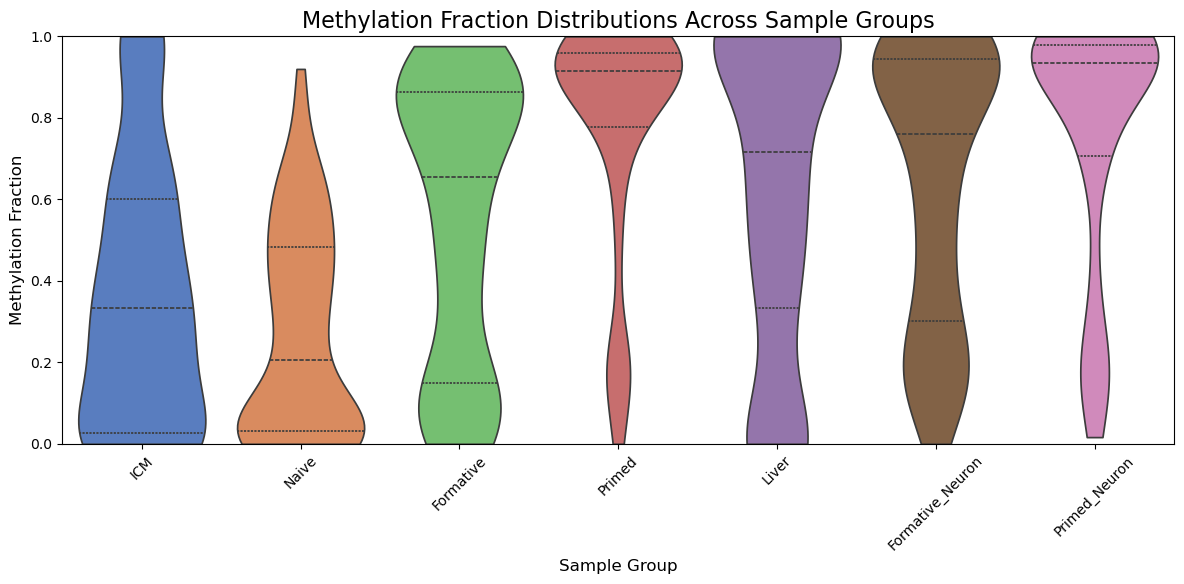

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Your methylation fraction columns (just a reminder)
frac_cols = [
    'ICM', 
    'Liver', 
    'Naive', 
    'Primed',
    'Primed_Neuron', 
    'Formative', 
    'Formative_Neuron'
]

# Melt the DataFrame from wide to long format for seaborn
plot_df = renamed_df[frac_cols].melt(var_name='Group', value_name='Methylation_Fraction')

# Optional: Set group order for plotting
group_order = ['ICM', 'Naive', 'Formative', 'Primed', 'Liver', 'Formative_Neuron', 'Primed_Neuron']
plot_df['Group'] = pd.Categorical(plot_df['Group'], categories=group_order, ordered=True)

# Plotting style
plt.rcParams.update({ 
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

# Create violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=plot_df,
    x='Group',
    y='Methylation_Fraction',
    palette='muted',
    inner='quartile',
    cut=0  # limits violin shape to observed data range
)

plt.ylim(0, 1.0)
plt.title('Methylation Fraction Distributions Across Sample Groups', fontsize=16)
plt.xlabel('Sample Group')
plt.ylabel('Methylation Fraction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("violin_liver_icm.pdf", format='pdf')
plt.savefig("violin_liver_icm.svg", format='svg')
plt.grid(False)
plt.show()


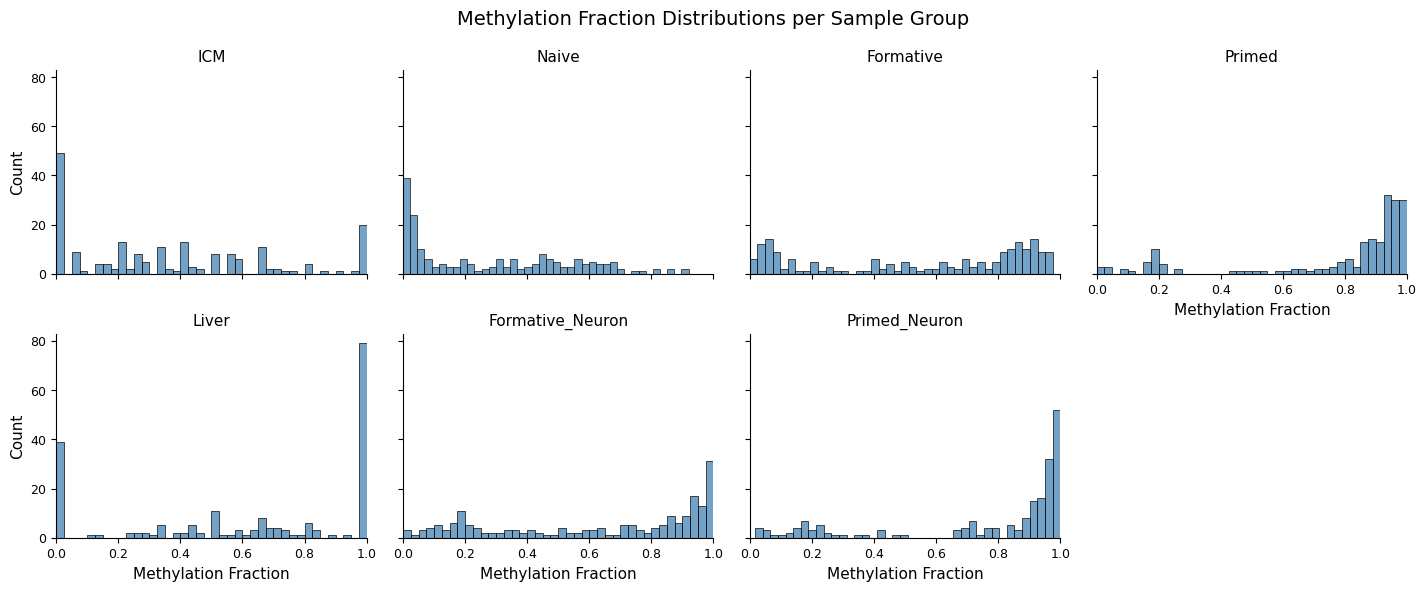

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Your methylation fraction columns
frac_cols = [
    'ICM', 
    'Liver', 
    'Naive', 
    'Primed',
    'Primed_Neuron', 
    'Formative', 
    'Formative_Neuron'
]

# Melt the DataFrame to long format
plot_df = renamed_df[frac_cols].melt(var_name='Group', value_name='Methylation_Fraction')

# Set group order
group_order = ['ICM', 'Naive', 'Formative', 'Primed', 'Liver', 'Formative_Neuron', 'Primed_Neuron']
plot_df['Group'] = pd.Categorical(plot_df['Group'], categories=group_order, ordered=True)

# Plotting style
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 10,
    'figure.titlesize': 14
})

# Create facet grid of histograms
g = sns.FacetGrid(
    plot_df,
    col='Group',
    col_order=group_order,
    col_wrap=4,
    sharex=True,
    sharey=True,
    height=3,
    aspect=1.2
)

g.map_dataframe(
    sns.histplot,
    x='Methylation_Fraction',
    bins=40,
    color='steelblue',
    edgecolor='black'
)

# Set axis limits and labels
g.set(xlim=(0, 1.0), ylim=(0, None))
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Methylation Fraction", "Count")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Methylation Fraction Distributions per Sample Group")
plt.tight_layout()
plt.savefig("histogram_liver_icm.pdf", format='pdf')
plt.savefig("histogram_liver_icm.svg", format='svg')
plt.show()



In [15]:
import numpy as np
from itertools import combinations
from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance  # EMD

# Methylation fraction groups (same as before)
frac_cols = ['ICM', 'Liver', 'Naive', 'Primed', 'Primed_Neuron', 'Formative', 'Formative_Neuron']

# Long-format data
plot_df = renamed_df[frac_cols].melt(var_name='Group', value_name='Methylation_Fraction')
plot_df = plot_df.dropna()

# Set group order
group_order = ['ICM', 'Naive', 'Formative', 'Primed', 'Liver', 'Formative_Neuron', 'Primed_Neuron']
plot_df['Group'] = pd.Categorical(plot_df['Group'], categories=group_order, ordered=True)

# Store test results
ks_results = []
emd_results = []

# Pairwise comparisons
for g1, g2 in combinations(group_order, 2):
    d1 = plot_df[plot_df['Group'] == g1]['Methylation_Fraction']
    d2 = plot_df[plot_df['Group'] == g2]['Methylation_Fraction']

    ks_stat, ks_pval = ks_2samp(d1, d2)
    emd_val = wasserstein_distance(d1, d2)

    ks_results.append({'Group1': g1, 'Group2': g2, 'KS_pval': ks_pval})
    emd_results.append({'Group1': g1, 'Group2': g2, 'EMD': emd_val})

ks_df = pd.DataFrame(ks_results)
emd_df = pd.DataFrame(emd_results)


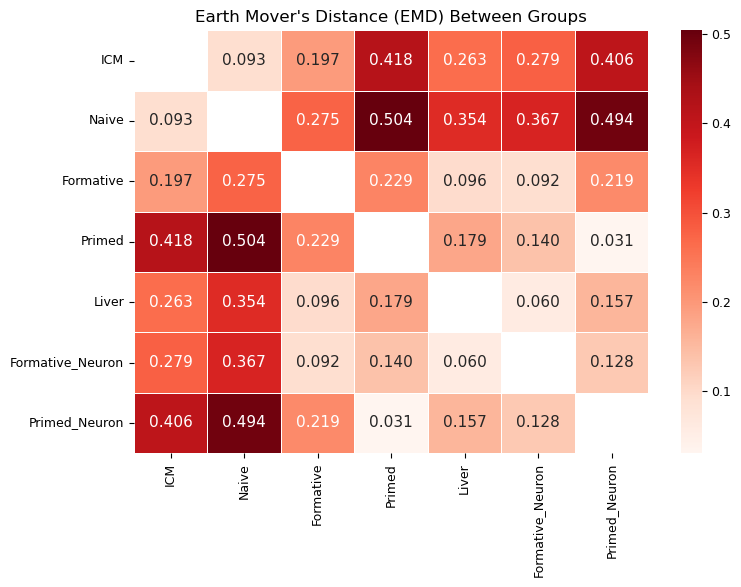

In [24]:
# Pivot to matrix for heatmap
emd_matrix = pd.DataFrame(index=group_order, columns=group_order, dtype=float)

for _, row in emd_df.iterrows():
    emd_matrix.loc[row['Group1'], row['Group2']] = row['EMD']
    emd_matrix.loc[row['Group2'], row['Group1']] = row['EMD']  # Symmetric

plt.figure(figsize=(8, 6))
sns.heatmap(emd_matrix, annot=True, cmap="Reds", fmt=".3f", linewidths=0.5)
plt.title('Earth Mover\'s Distance (EMD) Between Groups')
plt.tight_layout()
# Save as PDF and SVG
plt.savefig("emd_heatmap_liver_icm.pdf", format='pdf')
plt.savefig("emd_heatmap_liver_icm.svg", format='svg')
plt.show()

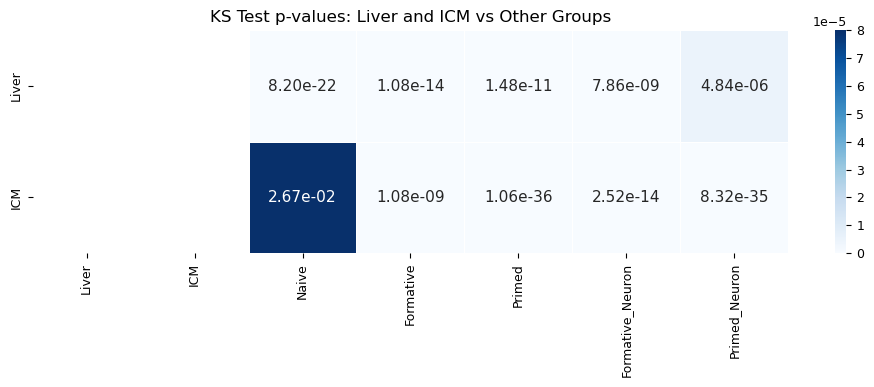

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define which comparisons to include (Liver or ICM vs others)
target_groups = ['Liver', 'ICM']

# Filter ks_df to keep only rows where one group is Liver or ICM and the other is not the same
filtered_ks_df = ks_df[
    ((ks_df['Group1'].isin(target_groups)) & (~ks_df['Group2'].isin(target_groups))) |
    ((ks_df['Group2'].isin(target_groups)) & (~ks_df['Group1'].isin(target_groups)))
]

# Create a subset of the full group list for rows/columns to include
included_groups = target_groups + [g for g in group_order if g not in target_groups]

# Initialize matrix with NaNs
ks_matrix = pd.DataFrame(index=target_groups, columns=included_groups, dtype=float)

# Fill matrix with p-values
for _, row in filtered_ks_df.iterrows():
    g1, g2, pval = row['Group1'], row['Group2'], row['KS_pval']
    if g1 in target_groups:
        ks_matrix.loc[g1, g2] = pval
    else:
        ks_matrix.loc[g2, g1] = pval

# Plot heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(
    ks_matrix,
    annot=True,
    cmap="Blues",
    fmt=".2e",
    linewidths=0.5,
    vmin=0,
    vmax=0.00008
)
plt.title('KS Test p-values: Liver and ICM vs Other Groups')
plt.tight_layout()
plt.show()
